In [30]:
import json
import os
from numpy import array
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Main Evaluation


In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D
from scipy import stats
no_neg_preds_value = 1.0

def get_metrics(folder, weights_to_eval, data = "compas", delta_max = 0.75, lime_kw = 0.5):
    f1s = []
    accuracies = []
    our_recourses, wachter_recourses = [], []
    our_flipped, wachter_flipped = [], []
    minority_recourses, white_recourses = [], []
    thresholds = []
    precisions, recalls = [], []
    for w in weights_to_eval:

        metric = "f1s"
        temp = pd.read_csv(folder + str(w) + '/test_eval/' + 'our_thresholds_test_results.csv', header=0, index_col='index')
        filtered = temp.iloc[temp[metric].argmax()]

        thresholds.append(filtered['thresholds'])
        f1s.append(filtered['f1s'])
        precisions.append(filtered['precisions'])
        accuracies.append(filtered['accuracies'])
        recalls.append(filtered['recalls'])
        
        our_recourses.append(filtered['recourse_proportion'])
        our_flipped.append(filtered['flipped_proportion'])

        temp = pd.read_csv(folder + str(w) + '/test_eval/' + 'wachter_thresholds_test_results.csv', header=0, index_col='index')
        new_filtered = temp.iloc[temp[metric].argmax()]
        assert(filtered['f1s'] == new_filtered['f1s'])
        wachter_recourses.append(new_filtered['recourse_proportion']) 
        wachter_flipped.append(new_filtered['flipped_proportion'])

    return f1s, accuracies, precisions, recalls, our_recourses, wachter_recourses, our_flipped, wachter_flipped, thresholds, minority_recourses, white_recourses
    
def plot_main_across_splits(results_folder = "results/",
                  delta_max = 0.75,
                  seeds = [0, 21, 42],
                  weights_to_eval=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
                  save_fig=False):

    datasets = ['adult', 'compas', 'bail', 'german']
    fig, (axes) = plt.subplots(3, len(datasets) ,figsize=(20,7))

    fig.subplots_adjust(hspace=0, wspace = 0.05)

    for data_idx, data in enumerate(datasets):
        metrics_by_weight = [[] for i in range(len(weights_to_eval))]

        for w_idx, w in enumerate(weights_to_eval):
            f1s, accuracies, our_recourses, wachter_recourses, our_flipped, wachter_flipped, thresholds = [], [], [], [], [], [], []
            print("WEIGHT: ", w)
            for seed in seeds:
                folder = results_folder + data + '_' + str(delta_max) + '/' + str(seed) + '/'
                output = get_metrics(folder, [w], delta_max = delta_max, data = data)
                f1s.extend(output[0])
                accuracies.extend(output[1])
                our_recourses.extend(output[4])
                wachter_recourses.extend(output[5])
                our_flipped.extend(output[6])
                wachter_flipped.extend(output[7])
                thresholds.extend(output[8])

            print("f1s: ", f1s)
            for idx, rec in enumerate(our_flipped):
                if our_flipped[idx] == 0.0 and our_recourses[idx] == 1.0:
                    our_flipped[idx] = no_neg_preds_value

            for idx, rec in enumerate(wachter_flipped):
                if wachter_flipped[idx] == 0.0 and wachter_recourses[idx] == 1.0:
                    wachter_flipped[idx] = no_neg_preds_value

            metrics_by_weight[w_idx] = {"f1s": f1s.copy(), "accuracies": accuracies.copy(), "our_recourses": our_recourses.copy() ,\
                                   "wachter_recourses": wachter_recourses.copy(), "our_flipped": our_flipped.copy(), \
                                        "wachter_flipped": wachter_flipped.copy(), "thresholds": thresholds.copy()}
            metrics_by_weight[w_idx] = {k: np.array(v) for k,v in metrics_by_weight[w_idx].items()}
            print("WEIGHT:", w)
            print("METRICS by seed, in order:", seeds)
            print(metrics_by_weight[w_idx])

        string_weights = [str(x) + "\n(BL)" if x == 0.0 else str(x) for x in (weights_to_eval)]

        our_flipped = [metrics_by_weight[w_idx]['our_flipped'].mean() for w_idx in range(len(weights_to_eval))]
        wachter_flipped = [metrics_by_weight[w_idx]['wachter_flipped'].mean() for w_idx in range(len(weights_to_eval))]
        our_recourses = [metrics_by_weight[w_idx]['our_recourses'].mean() for w_idx in range(len(weights_to_eval))]
        wachter_recourses = [metrics_by_weight[w_idx]['wachter_recourses'].mean() for w_idx in range(len(weights_to_eval))]
        f1s = [metrics_by_weight[w_idx]['f1s'].mean() for w_idx in range(len(weights_to_eval))]
        accuracies = [metrics_by_weight[w_idx]['accuracies'].mean() for w_idx in range(len(weights_to_eval))]

        print('mean f1s:', f1s)
        print('mean our recourse all:', our_recourses)
        print('mean wachter recourse all:', wachter_recourses)
        
        our_flipped_error = [metrics_by_weight[w_idx]['our_flipped'].std() for w_idx in range(len(weights_to_eval))]
        wachter_flipped_error = [metrics_by_weight[w_idx]['wachter_flipped'].std() for w_idx in range(len(weights_to_eval))]
        our_recourses_error = [metrics_by_weight[w_idx]['our_recourses'].std() for w_idx in range(len(weights_to_eval))]
        wachter_recourses_error = [metrics_by_weight[w_idx]['wachter_recourses'].std() for w_idx in range(len(weights_to_eval))]
        f1s_error = [metrics_by_weight[w_idx]['f1s'].std() for w_idx in range(len(weights_to_eval))]
        accuracies_error = [metrics_by_weight[w_idx]['accuracies'].std() for w_idx in range(len(weights_to_eval))]

        
        wachter_color = '#AF7AC5'
        our_color = '#1ABC9C'

        ax1 = axes[0][data_idx]
        ax2 = axes[1][data_idx]
        ax3 = axes[2][data_idx]

        marker_size = 8

        ax2.errorbar(string_weights, our_flipped, our_flipped_error, color=our_color, marker='o', linestyle='dashed', linewidth=2, markersize=marker_size)
        ax2.errorbar(string_weights, wachter_flipped, wachter_flipped_error, color=wachter_color, marker='o', linestyle='dashed', linewidth=2, markersize=marker_size)
        ax1.errorbar(string_weights, accuracies, accuracies_error, color='silver', marker='o', linestyle='solid', linewidth=2, markersize=marker_size)
        ax1.errorbar(string_weights, f1s, f1s_error, color='gray', marker='o', linestyle='solid', linewidth=2, markersize=marker_size)
        ax3.errorbar(string_weights, our_recourses, our_recourses_error, color=our_color, marker='o', linestyle='solid', linewidth=2, markersize=marker_size)
        ax3.errorbar(string_weights, wachter_recourses, wachter_recourses_error, color=wachter_color, marker='o', linestyle='solid', linewidth=2, markersize=marker_size)

        acc = Line2D([0], [0], color='silver', linewidth=2, linestyle='solid', label = 'Accuracies')
        F1 = Line2D([0], [0], color='gray', linewidth=2, linestyle='solid', label = 'F1 scores')
        our_recourse = Line2D([0], [0], color=our_color, linewidth=2, linestyle='solid', label = 'LP, Ours (All)')
        wachter_recourse = Line2D([0], [0], color=our_color, linewidth=2, linestyle='dashed', label = 'LP, Ours (Neg)')
        our_neg_recourse = Line2D([0], [0], color=wachter_color, linewidth=2, linestyle='solid', label = 'Wachter (All)')
        wachter_neg_recourse = Line2D([0], [0], color=wachter_color, linewidth=2, linestyle='dashed', label = 'Wachter (Neg)')

        print("thresholds: ", thresholds)

        ax1.set_ylim(0.0, 1.1)
        ax2.set_ylim(-0.1, 1.1)
        ax3.set_ylim(-0.1, 1.1)

        ax1.set_title(data, fontsize=18)
        if data_idx == 0:
            ax1.set_ylabel("Performance", fontsize=16)
            ax2.set_ylabel("Recourse (Neg)", fontsize=16)
            ax3.set_ylabel("Recourse (All)", fontsize=16)

            ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

            ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax3.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

        else:
            ax1.set_yticks([])
            ax2.set_yticks([])
            ax3.set_yticks([])

        if data_idx == 1:
            ax3.set_xlabel(r'$\lambda$', fontsize=16)


        ax3.tick_params(axis='both', which='major', labelsize=13)


        ax1.set_xticks([]) 
        ax2.set_xticks([]) 

    if save_fig:
        save_path=os.path.join(figure_folder, 'main.pdf')
        plt.savefig(save_path, bbox_inches="tight")
    

WEIGHT:  0.0
f1s:  [0.686, 0.687, 0.719]
WEIGHT: 0.0
METRICS by seed, in order: [0, 21, 42]
{'f1s': array([0.686, 0.687, 0.719]), 'accuracies': array([0.828, 0.814, 0.848]), 'our_recourses': array([0.318, 0.358, 0.286]), 'wachter_recourses': array([0.414, 0.47 , 0.498]), 'our_flipped': array([0.   , 0.021, 0.   ]), 'wachter_flipped': array([0.141, 0.192, 0.297]), 'thresholds': array([0.65, 0.55, 0.55])}
WEIGHT:  0.2
f1s:  [0.674, 0.691, 0.674]
WEIGHT: 0.2
METRICS by seed, in order: [0, 21, 42]
{'f1s': array([0.674, 0.691, 0.674]), 'accuracies': array([0.83 , 0.828, 0.83 ]), 'our_recourses': array([0.362, 0.376, 0.38 ]), 'wachter_recourses': array([0.328, 0.41 , 0.462]), 'our_flipped': array([0.099, 0.101, 0.153]), 'wachter_flipped': array([0.051, 0.15 , 0.265]), 'thresholds': array([0.7 , 0.65, 0.6 ])}
WEIGHT:  0.4
f1s:  [0.664, 0.671, 0.659]
WEIGHT: 0.4
METRICS by seed, in order: [0, 21, 42]
{'f1s': array([0.664, 0.671, 0.659]), 'accuracies': array([0.82 , 0.814, 0.814]), 'our_recours

f1s:  [0.773, 0.773, 0.771]
WEIGHT: 1.0
METRICS by seed, in order: [0, 21, 42]
{'f1s': array([0.773, 0.773, 0.771]), 'accuracies': array([0.634, 0.644, 0.632]), 'our_recourses': array([1., 1., 1.]), 'wachter_recourses': array([1., 1., 1.]), 'our_flipped': array([1., 1., 1.]), 'wachter_flipped': array([1., 1., 1.]), 'thresholds': array([0.35, 0.45, 0.45])}
WEIGHT:  1.2
f1s:  [0.771, 0.788, 0.77]
WEIGHT: 1.2
METRICS by seed, in order: [0, 21, 42]
{'f1s': array([0.771, 0.788, 0.77 ]), 'accuracies': array([0.628, 0.652, 0.626]), 'our_recourses': array([1., 1., 1.]), 'wachter_recourses': array([1., 1., 1.]), 'our_flipped': array([1., 1., 1.]), 'wachter_flipped': array([1., 1., 1.]), 'thresholds': array([0.3 , 0.3 , 0.35])}
WEIGHT:  1.4
f1s:  [0.771, 0.79, 0.779]
WEIGHT: 1.4
METRICS by seed, in order: [0, 21, 42]
{'f1s': array([0.771, 0.79 , 0.779]), 'accuracies': array([0.628, 0.654, 0.648]), 'our_recourses': array([1., 1., 1.]), 'wachter_recourses': array([1., 1., 1.]), 'our_flipped': arra

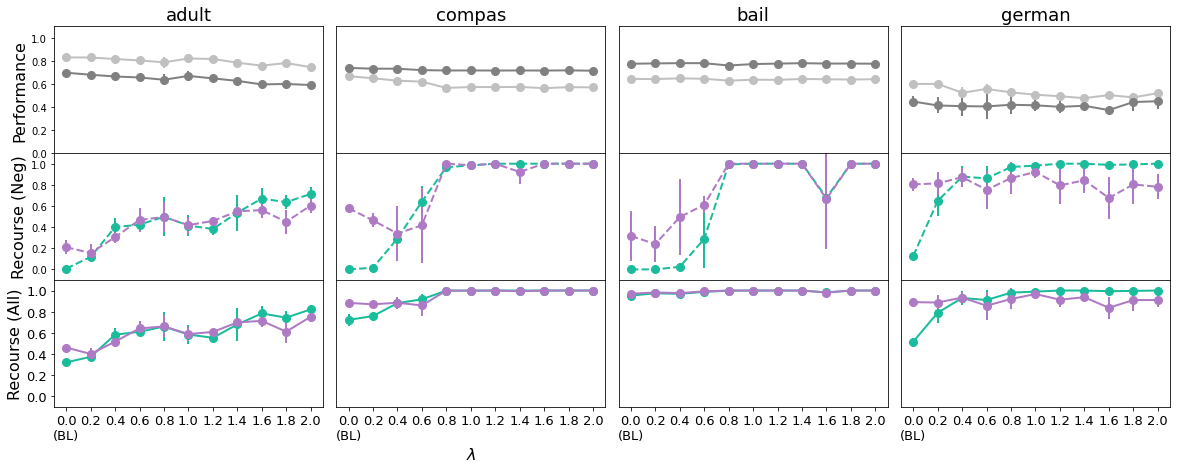

In [34]:
plot_main_across_splits(results_folder="results/", save_fig=False)


## Main Latex Table

In [35]:
def get_row(folder, w, metric):
    assert metric in ["thresholds", "f1s", "accuracies", "precisions", "recalls", "wachter_recourse_proportion", "wachter_flipped_proportion", "our_recourse_proportion", "our_flipped_proportion"]

    if "our_" in metric:
        eval_type = "our"
        metric = metric[4:]
    elif "wachter_" in metric:
        eval_type = "wachter"
        metric = metric[8:]
    else:
        eval_type = "our"
    temp = pd.read_csv(folder + str(w) + "/test_eval/" + eval_type + "_thresholds_test_results.csv", header=0, index_col='index')
    assert len(temp) == 1
    filtered = temp.iloc[0]
        
    return filtered[metric]
        
def get_latex_main_results(weights, results_folder="results/", 
                           seeds=[0, 21, 42], delta_max=0.75, 
                           datasets=["adult", "compas", "bail"],
                           include_std = False):
    
    f1s = []
    row_string = ""
    
    metric_mapping = {
        "thresholds": "Thresholds ($\\theta_0$)",
        "f1s": "F1 score",
        "accuracies": "Accuracy",
        "precisions": "Precision",
        "recalls": "Recall",
        "our_recourse_proportion": "Adversarial train.",
        "our_flipped_proportion": "Adversarial train.",
        "wachter_recourse_proportion": "Gradient desc.",
        "wachter_flipped_proportion": "Gradient desc.",
    }
    
    metrics = ["thresholds", "f1s", "accuracies", "precisions", "recalls", \
               "lime", "wachter_flipped_proportion", "our_flipped_proportion", "lime", "wachter_recourse_proportion", "our_recourse_proportion"]
    for metric in metrics:
        if metric == "lime":
            row_string = "Linear approx. & -- & - & -- & -- & -- & --\\\\\n"
            print(row_string)
            continue
                
        row_string = metric_mapping[metric]
        for data in datasets:
#             row_string += " &"
            
            means = []
            stdevs = []
            for w in weights:
                seed_values = []
                for seed in seeds:
                    folder = results_folder + data + "_" + str(delta_max) + "/" + str(seed) + "/"
                    value = round(get_row(folder, w, metric), 3)
                    seed_values.append(value)
                seed_values = np.array(seed_values)
                mean = round(np.mean(seed_values), 3)
                stdev = round(np.std(seed_values), 3)
                means.append(mean)
                stdevs.append(stdev)
            max_value = max(means)
            for mean, stdev in zip(means, stdevs):
                row_string += "& "
                if mean == max_value and metric != "thresholds":
                    row_string += "\\textbf{" + '{:.3f}'.format(float(mean)) + "}"
                else:
                    row_string += '{:.3f}'.format(float(mean))
                if metric != "thresholds" and include_std:
                    row_string += f" $\pm$ " +'{:.3f}'.format(float(stdev))
        row_string += "\\\\"

        if metric == "thresholds":
            row_string += "\midrule"
        elif metric == "recalls":
            row_string += "\midrule\midrule"
        elif metric == "our_flipped_proportion":
            row_string += "\midrule"
        row_string += "\n"

        print(row_string)

In [36]:
get_latex_main_results(weights=[0.0, 0.8], 
                       results_folder="results/",
                       datasets=["adult", "compas", "bail", "german"])


Thresholds ($\theta_0$)& 0.583& 0.733& 0.367& 0.400& 0.283& 0.417& 0.467& 0.567\\\midrule

F1 score& \textbf{0.697}& 0.636& \textbf{0.739}& 0.717& \textbf{0.775}& 0.760& \textbf{0.447}& 0.419\\

Accuracy& \textbf{0.830}& 0.787& \textbf{0.667}& 0.565& \textbf{0.643}& 0.629& \textbf{0.600}& 0.527\\

Precision& \textbf{0.621}& 0.555& \textbf{0.655}& 0.561& \textbf{0.646}& 0.644& \textbf{0.364}& 0.317\\

Recall& \textbf{0.799}& 0.752& 0.850& \textbf{0.991}& \textbf{0.968}& 0.930& 0.583& \textbf{0.638}\\\midrule\midrule

Linear approx. & -- & - & -- & -- & -- & --\\

Gradient desc.& 0.210& \textbf{0.496}& 0.579& \textbf{1.000}& 0.317& \textbf{1.000}& 0.804& \textbf{0.864}\\

Adversarial train.& 0.007& \textbf{0.498}& 0.000& \textbf{0.967}& 0.000& \textbf{0.993}& 0.127& \textbf{0.968}\\\midrule

Linear approx. & -- & - & -- & -- & -- & --\\

Gradient desc.& 0.461& \textbf{0.661}& 0.883& \textbf{1.000}& 0.970& \textbf{1.000}& 0.890& \textbf{0.920}\\

Adversarial train.& 0.321& \textbf{0.659}&

## Causal Evaluation on German Dataset

In [14]:
def plot_causal(
    weights_to_eval = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
    seeds = [0, 42, 21, 1, 2, 3, 4, 7, 8, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22],
    results_folder="results/",
    figure_folder="figures/",
    save_fig=False):
    
    """ Plots Figure 3 in paper. """
    
    means = []
    errors = []
    for weight in weights_to_eval:
        validities = []
        for seed in seeds:
            filename = f"{results_folder}/german_0.75/{seed}/{weight}/test_eval/causal_evaluation.txt"
            obj = eval(open(filename, 'r').read())
            validities.append(obj['validity'])
        means.append(np.mean(validities))
        errors.append(stats.sem(validities))
    string_weights = [str(x) + "\n(BL)" if x == 0.0 else str(x) for x in (weights_to_eval)]
    assert len(means) == len(string_weights)

    fig = plt.figure()
    plt.errorbar(string_weights, means, errors, marker='o', linestyle='dashed', linewidth=2, markersize=9)
    plt.ylim(0.4, 1.0)
    plt.xlabel(r'$\lambda$', fontsize=16, labelpad=-5)
    plt.ylabel("Recourse (Neg)", fontsize=16)
    if save_fig:
        save_path=os.path.join(figure_folder, 'causal.pdf')
        plt.savefig(save_path)
    plt.title("german: causal recourse rates")
    plt.subplots_adjust(hspace=0, wspace = 0.05)
    fig.patch.set_facecolor('white')

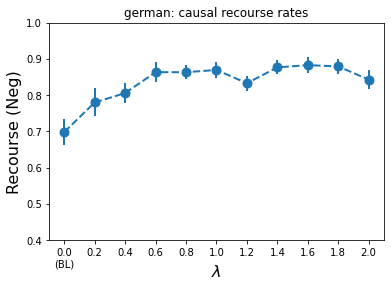

In [17]:
plot_causal(results_folder="results")